In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Set Seaborn style
sns.set_style("darkgrid")

# Define file path
file_path = "/content/Zomato.csv"


In [34]:
# Load the dataset
df = pd.read_csv(file_path)

# Clean column names
df.columns = df.columns.str.strip()

# Rename 'close' column if necessary
if "close" in df.columns:
    df.rename(columns={"close": "Close"}, inplace=True)

# Convert 'Date' column to datetime format
df["Date"] = pd.to_datetime(df["Date"], format="%d-%b-%Y")

# Keep only relevant columns
df = df[["Date", "Close"]]

# Sort data by date
df = df.sort_values("Date")

# Display the first few rows
df.head(5)


,Date,Close
248,2024-02-05,140.25
247,2024-02-06,139.95
246,2024-02-07,140.40
245,2024-02-08,144.10
244,2024-02-09,149.45


<Figure size 1200x500 with 0 Axes>

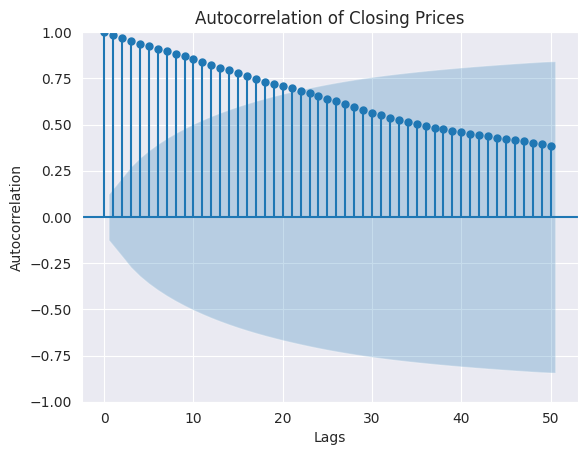

<Figure size 1200x500 with 0 Axes>

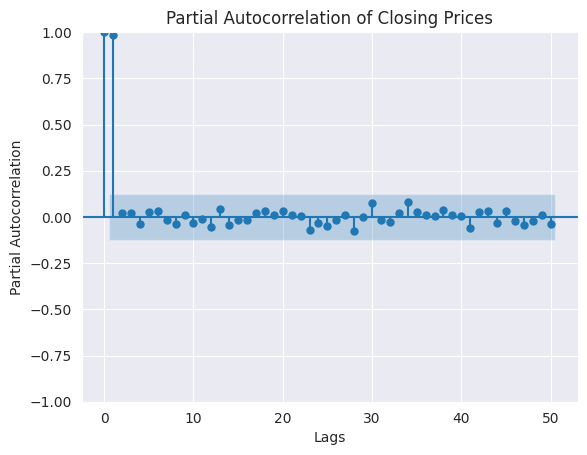

In [35]:
# Import required functions for ACF and PACF plots


# Autocorrelation of Closing Prices
plt.figure(figsize=(12, 5))
plot_acf(df['Close'].dropna(), lags=50)
plt.title('Autocorrelation of Closing Prices')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

# Partial Autocorrelation of Closing Prices
plt.figure(figsize=(12, 5))
plot_pacf(df['Close'].dropna(), lags=50, method='ywm')
plt.title('Partial Autocorrelation of Closing Prices')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()


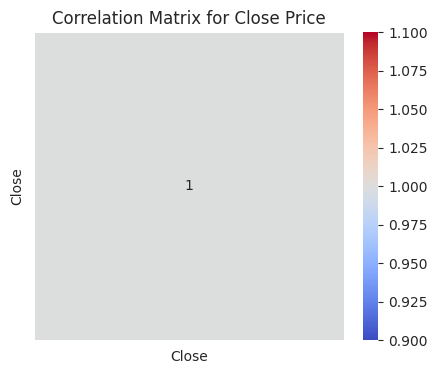

In [36]:
# Since only the 'Close' column is available, the correlation matrix is trivial.
corr_matrix = df[['Close']].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for Close Price')
plt.show()


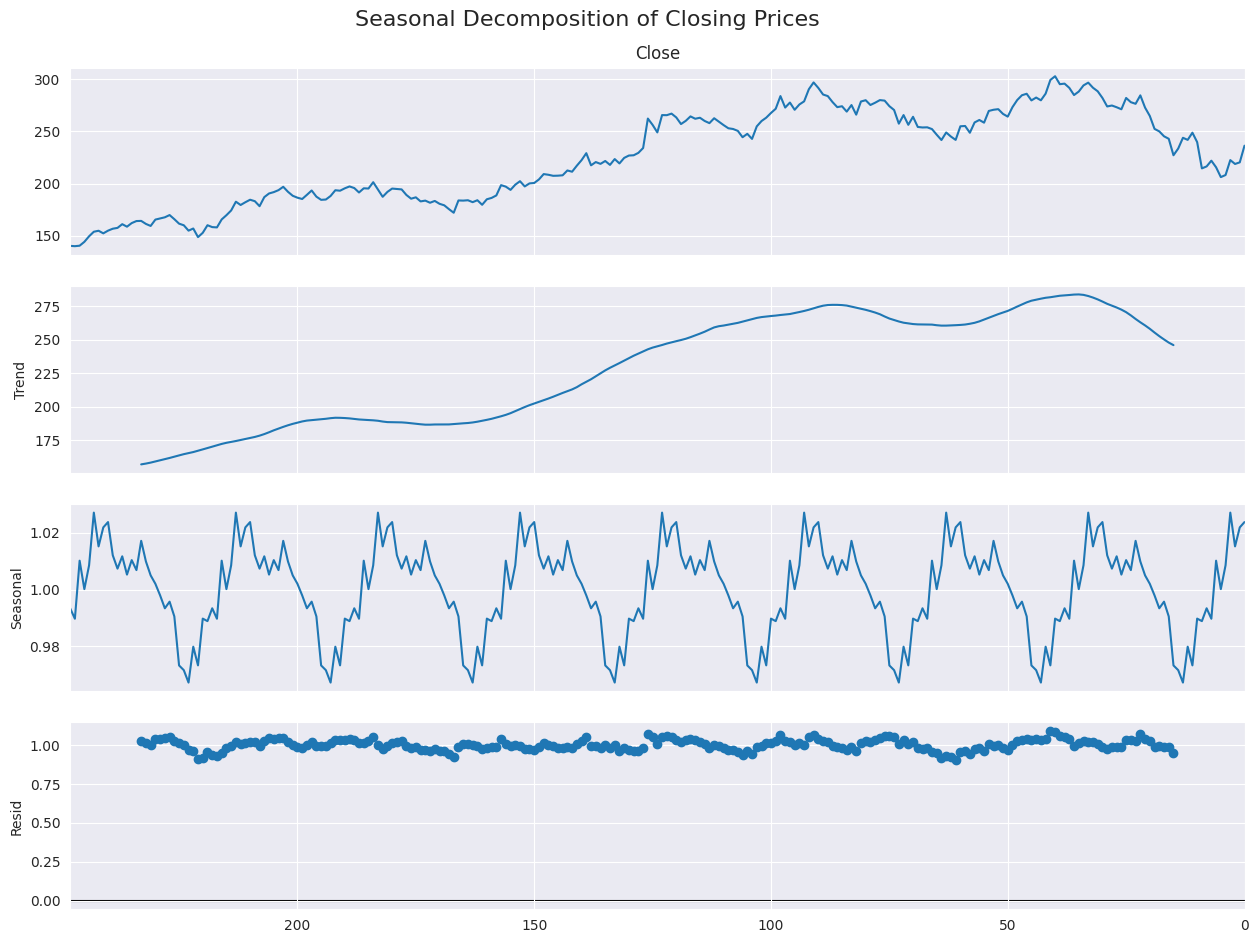

In [37]:

# Decompose the 'Close' price series. Adjust period if necessary.
decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=30)

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle('Seasonal Decomposition of Closing Prices', fontsize=16)
plt.show()


In [38]:
# Display summary statistics
df.describe()


,Date,Close
count,249,249.000000
mean,2024-08-05 01:26:44.819277056,225.411928
min,2024-02-05 00:00:00,139.950000
25%,2024-05-08 00:00:00,186.800000
50%,2024-08-06 00:00:00,223.490000
75%,2024-11-04 00:00:00,265.670000
max,2025-02-01 00:00:00,302.950000
std,NaN,44.501981


In [39]:
# Check for missing values
df.isnull().sum()


,0
Date,0
Close,0


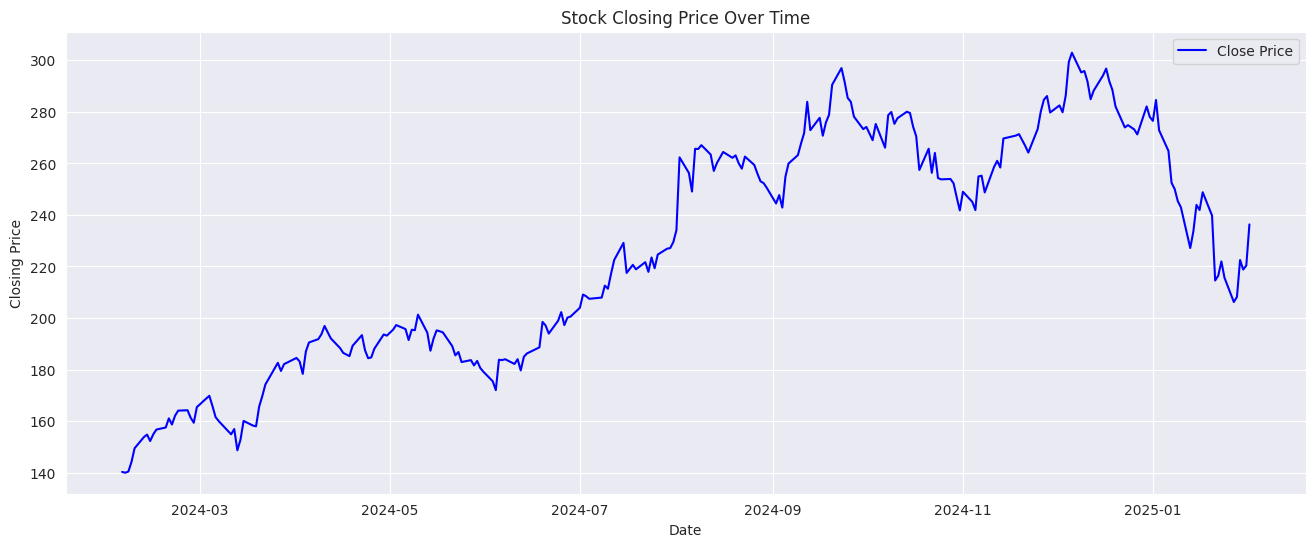

In [40]:
# Plot closing price over time
plt.figure(figsize=(16, 6))
plt.plot(df["Date"], df["Close"], label="Close Price", color="blue")
plt.title("Stock Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()


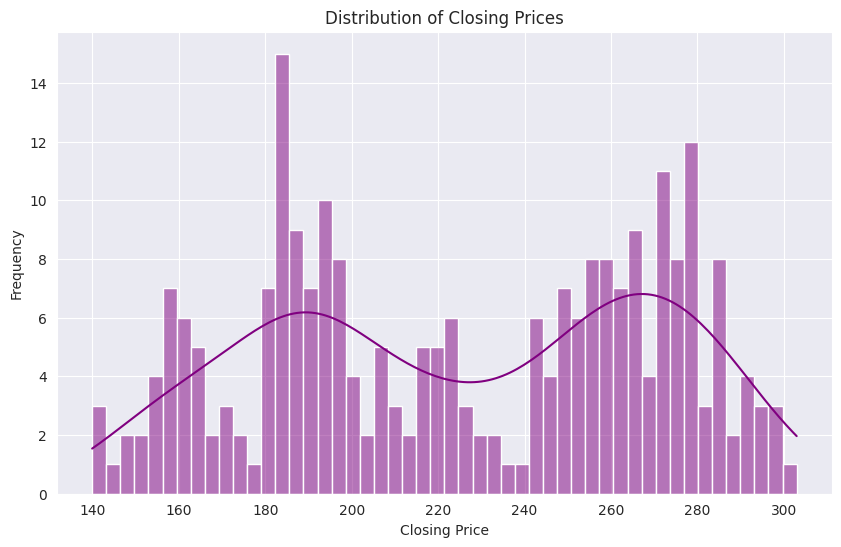

In [41]:
# Distribution of closing prices
plt.figure(figsize=(10, 6))
sns.histplot(df["Close"], bins=50, kde=True, color="purple")
plt.title("Distribution of Closing Prices")
plt.xlabel("Closing Price")
plt.ylabel("Frequency")
plt.show()


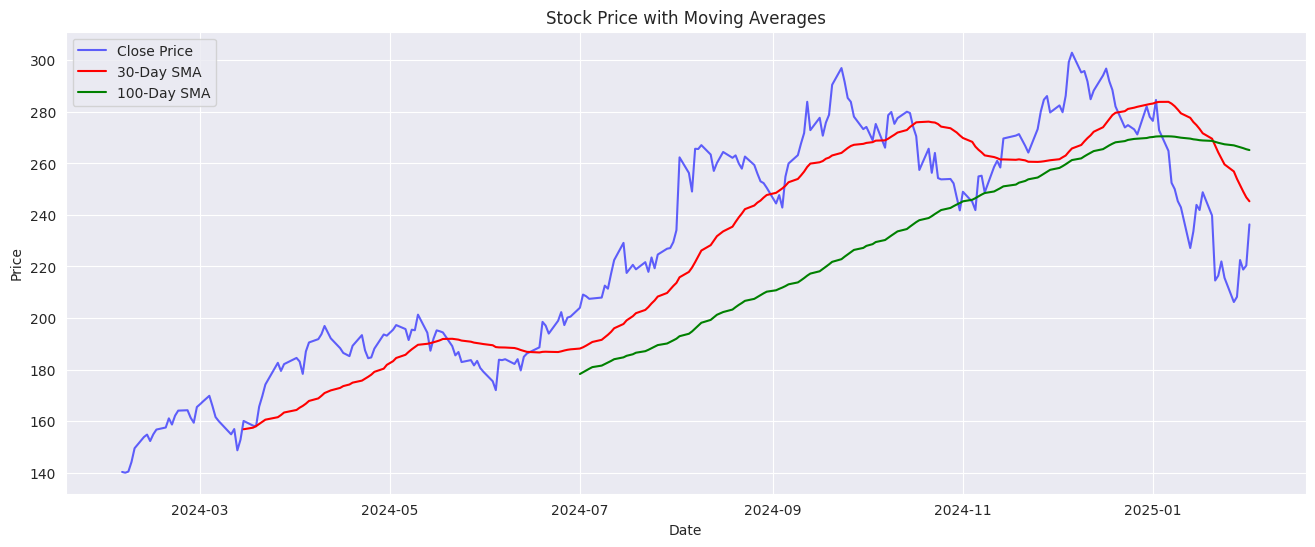

In [42]:
# Compute and plot moving averages
df["SMA_30"] = df["Close"].rolling(window=30).mean()
df["SMA_100"] = df["Close"].rolling(window=100).mean()

plt.figure(figsize=(16, 6))
plt.plot(df["Date"], df["Close"], label="Close Price", color="blue", alpha=0.6)
plt.plot(df["Date"], df["SMA_30"], label="30-Day SMA", color="red")
plt.plot(df["Date"], df["SMA_100"], label="100-Day SMA", color="green")
plt.title("Stock Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


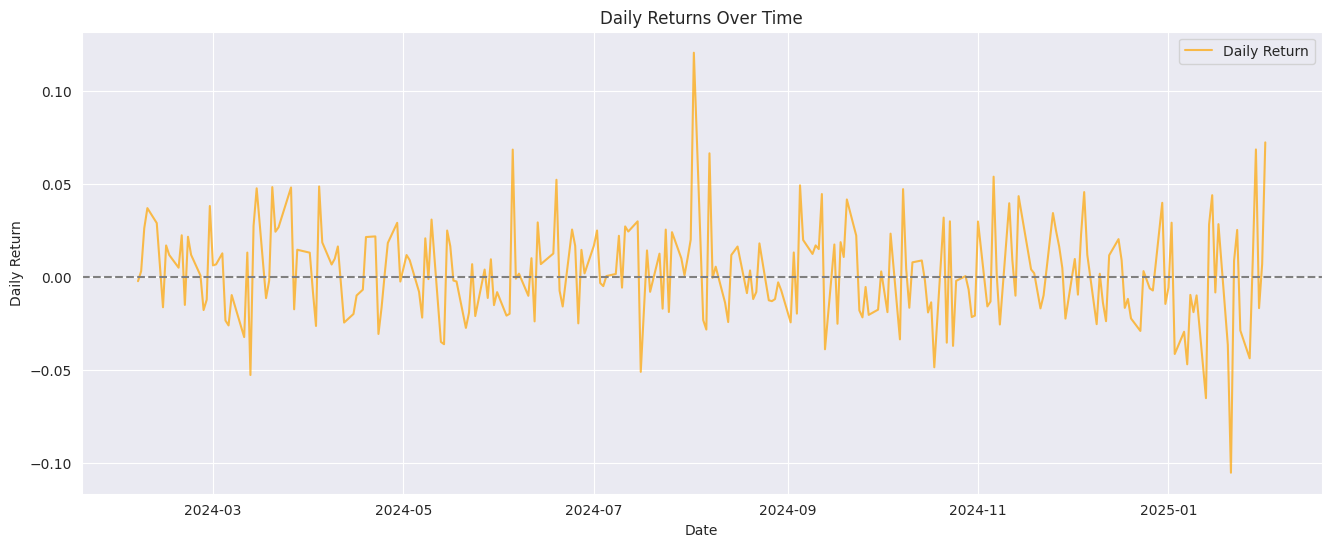

In [43]:
# Calculate and plot daily returns
df["Daily Return"] = df["Close"].pct_change()

plt.figure(figsize=(16, 6))
plt.plot(df["Date"], df["Daily Return"], label="Daily Return", color="orange", alpha=0.7)
plt.title("Daily Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.axhline(0, linestyle="--", color="gray")
plt.legend()
plt.show()


In [44]:
# Normalize closing prices
scaler = MinMaxScaler(feature_range=(0, 1))
df["Scaled_Close"] = scaler.fit_transform(df[["Close"]])

# Convert to numpy array
final_dataset = df["Scaled_Close"].values

# Define train-test split (80% train, 20% validation)
train_size = int(len(final_dataset) * 0.8)
train_data = final_dataset[:train_size]
valid_data = final_dataset[train_size:]


In [45]:
# Function to create sequences
def create_sequences(data, seq_length=90):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i - seq_length : i])  # Past 90 values
        y.append(data[i])  # Target value
    return np.array(x), np.array(y)

# Create sequences
x_train, y_train = create_sequences(train_data)

# Reshape for LSTM input format
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [46]:
# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(loss="mean_squared_error", optimizer="adam")

# Train the model
lstm_model.fit(x_train, y_train, epochs=50, batch_size=16, verbose=2)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 - 4s - 607ms/step - loss: 0.1987
Epoch 2/50
7/7 - 1s - 91ms/step - loss: 0.0308
Epoch 3/50
7/7 - 0s - 69ms/step - loss: 0.0136
Epoch 4/50
7/7 - 1s - 94ms/step - loss: 0.0074
Epoch 5/50
7/7 - 1s - 87ms/step - loss: 0.0079
Epoch 6/50
7/7 - 1s - 91ms/step - loss: 0.0061
Epoch 7/50
7/7 - 0s - 70ms/step - loss: 0.0054
Epoch 8/50
7/7 - 1s - 89ms/step - loss: 0.0052
Epoch 9/50
7/7 - 1s - 92ms/step - loss: 0.0054
Epoch 10/50
7/7 - 0s - 70ms/step - loss: 0.0050
Epoch 11/50
7/7 - 1s - 127ms/step - loss: 0.0050
Epoch 12/50
7/7 - 1s - 109ms/step - loss: 0.0049
Epoch 13/50
7/7 - 1s - 192ms/step - loss: 0.0049
Epoch 14/50
7/7 - 1s - 121ms/step - loss: 0.0048
Epoch 15/50
7/7 - 1s - 96ms/step - loss: 0.0048
Epoch 16/50
7/7 - 0s - 71ms/step - loss: 0.0049
Epoch 17/50
7/7 - 1s - 89ms/step - loss: 0.0047
Epoch 18/50
7/7 - 0s - 70ms/step - loss: 0.0047
Epoch 19/50
7/7 - 1s - 72ms/step - loss: 0.0047
Epoch 20/50
7/7 - 0s - 70ms/step - loss: 0.0047
Epoch 21/50
7/7 - 1s - 94ms/step - loss: 0.0048
Epoch 2

In [47]:
# Prepare test data
inputs = final_dataset[len(final_dataset) - len(valid_data) - 90 :]

# Create sequences for testing
x_test, _ = create_sequences(inputs)

# Reshape test data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Predict stock prices
predictions = lstm_model.predict(x_test)

# Reverse scaling
predictions = scaler.inverse_transform(predictions)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


In [48]:
# Save trained model
lstm_model.save("/content/saved_lstm_model.h5")


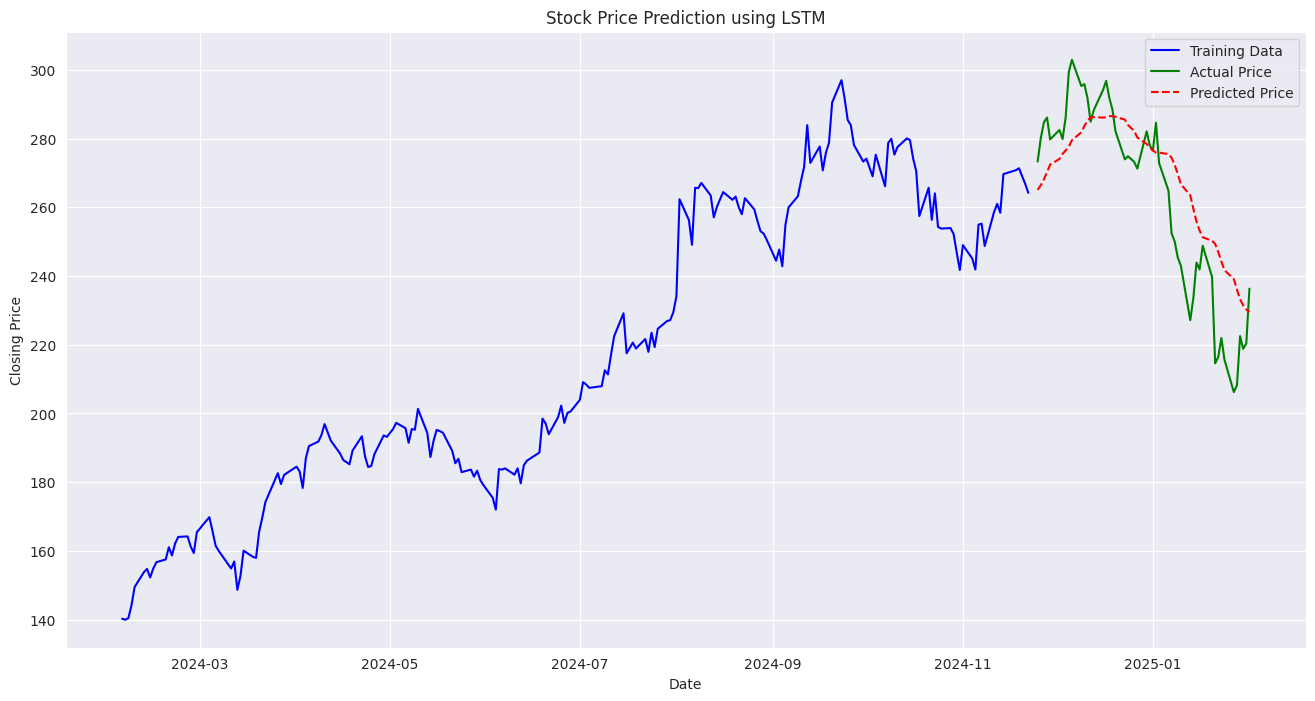

In [49]:
# Prepare DataFrame for visualization
df_valid = df.iloc[train_size:].copy()

# Adjust predictions length to match df_valid
predictions = predictions[:len(df_valid)]  # Trim or pad if necessary

df_valid["Predictions"] = predictions

# Plot actual vs predicted prices
plt.figure(figsize=(16, 8))
plt.plot(df["Date"][:train_size], df["Close"][:train_size], label="Training Data", color="blue")
plt.plot(df_valid["Date"], df_valid["Close"], label="Actual Price", color="green")
plt.plot(df_valid["Date"], df_valid["Predictions"], label="Predicted Price", linestyle="dashed", color="red")
plt.title("Stock Price Prediction using LSTM")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()
